<a href="https://colab.research.google.com/github/MosesIbe23/CSE_450_Private/blob/main/notebooks/starter_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
#bikes.info()
bikes.head()
#bikes.describe()

#bikes.isnull().sum()



,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday
0,1/1/2011,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0
1,1/1/2011,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0
2,1/1/2011,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0
3,1/1/2011,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0
4,1/1/2011,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0


In [99]:
from sklearn.preprocessing import MinMaxScaler

bikes['total_rentals'] = bikes['casual'] + bikes['registered']
bikes['temp_wind_interaction'] = bikes['temp_c'] * bikes['windspeed']  # interaction between temp and windspeed
bikes['temp_humidity_interaction'] = bikes['temp_c'] * bikes['hum']  # interaction between temp and humidity

bikes['temp_f'] = bikes['temp_c'] * (9/5) + 32
bikes['feels_like_f'] = bikes['feels_like_c'] * (9/5) + 32

# Ensure 'dteday' is converted to datetime format and save it back to the column
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

bikes['day_of_week'] = pd.to_datetime(bikes['dteday']).dt.dayofweek
bikes['month'] = bikes['dteday'].dt.month
bikes['year'] = bikes['dteday'].dt.year
bikes['hour'] = bikes['hr']

bikes.drop(columns=['dteday', 'temp_c', 'feels_like_c', 'hr', 'casual', 'registered'], inplace=True)

#bikes.head()

#Scale numerical features

scaler = MinMaxScaler()
numeric_features = ['hour', 'temp_f', 'feels_like_f', 'windspeed', 'temp_wind_interaction', 'temp_humidity_interaction']
bikes[numeric_features] = scaler.fit_transform(bikes[numeric_features])

# One-hot encode categorical features
categorical_features = ['season', 'weathersit', 'day_of_week', 'month', 'year', 'holiday', 'workingday']
bikes = pd.get_dummies(bikes, columns=categorical_features)

bikes.head()

,hum,windspeed,total_rentals,temp_wind_interaction,temp_humidity_interaction,temp_f,feels_like_f,hour,season_1,season_2,...,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,holiday_0,holiday_1,workingday_0,workingday_1
0,0.7957,0.011461,16,0.230276,0.336300,0.320652,0.366848,0.000000,True,False,...,False,False,False,False,False,False,True,False,True,False
1,0.8272,0.011461,38,0.229811,0.307613,0.297101,0.349185,0.043478,True,False,...,False,False,False,False,False,False,True,False,True,False
2,0.8157,0.015759,31,0.230137,0.311812,0.300725,0.351902,0.086957,True,False,...,False,False,False,False,False,False,True,False,True,False
3,0.7831,0.011461,12,0.230097,0.323743,0.311594,0.360054,0.130435,True,False,...,False,False,False,False,False,False,True,False,True,False
4,0.8075,0.015759,1,0.230186,0.313718,0.302536,0.353261,0.173913,True,False,...,False,False,False,False,False,False,True,False,True,False


In [65]:
#pip install scikeras

In [100]:
from sklearn.model_selection import train_test_split

X = bikes.drop(columns=['total_rentals'])
y = bikes['total_rentals']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2812/2812 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 90168.3281 - mae: 214.9152 - val_loss: 37308.2266 - val_mae: 121.5803
Epoch 2/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 33028.6523 - mae: 117.1726 - val_loss: 19225.6777 - val_mae: 88.5541
Epoch 3/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 17962.3496 - mae: 85.6265 - val_loss: 10967.0527 - val_mae: 66.3768
Epoch 4/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 11243.9883 - mae: 67.3119 - val_loss: 13288.7129 - val_mae: 75.2107
Epoch 5/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 9085.8018 - mae: 60.5144 - val_loss: 7515.4985 - val_mae: 55.1160
Epoch 6/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7983.8232 - mae: 56.6988 - val_loss: 7972.5464 - val_mae: 56.5322
Epoch 7/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7854.5898 - mae: 55.9168 - val_loss: 6757.2549 - val_mae: 51.2727
Epoch 8/100
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7698.3921 - mae: 54.9537 - val_

Baseline MAE: 268.97470685763017
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Validation MAPE (non-zero values): 35.14%
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


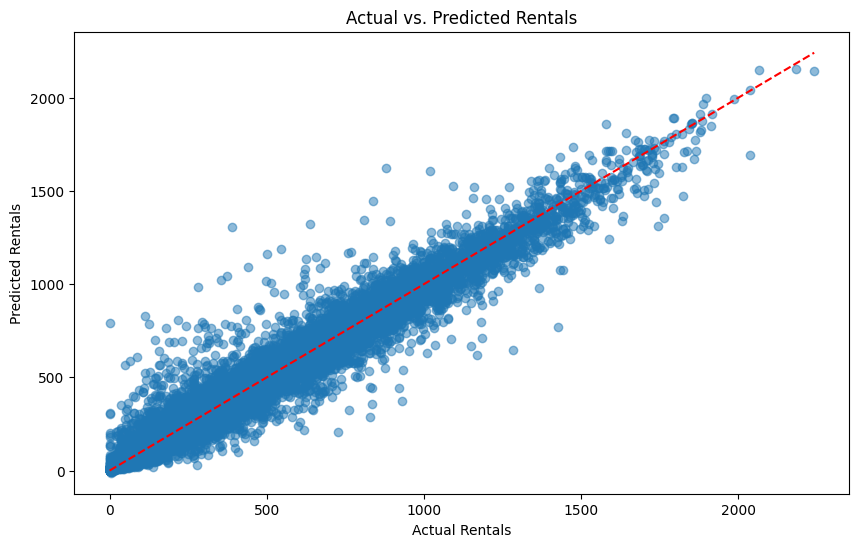

In [103]:
baseline_mae = abs(y_val.mean() - y_val).mean()
print(f"Baseline MAE: {baseline_mae}")

# Calculate MAPE only for non-zero actual values
y_val_nonzero = y_val[y_val != 0]
predictions_nonzero = model.predict(X_val).flatten()[y_val != 0]

mape = (abs(y_val_nonzero - predictions_nonzero) / y_val_nonzero).mean() * 100
print(f"Validation MAPE (non-zero values): {mape:.2f}%")

import matplotlib.pyplot as plt

# Predict on validation set
predictions = model.predict(X_val).flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line for perfect prediction
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Actual vs. Predicted Rentals")
plt.show()

In [114]:
# Load December data
december_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')
december_data.head()

from sklearn.preprocessing import MinMaxScaler

bikes2 = december_data
bikes2['temp_wind_interaction'] = bikes2['temp_c'] * bikes2['windspeed']  # interaction between temp and windspeed
bikes2['temp_humidity_interaction'] = bikes2['temp_c'] * bikes2['hum']  # interaction between temp and humidity

bikes2['temp_f'] = bikes2['temp_c'] * (9/5) + 32
bikes2['feels_like_f'] = bikes2['feels_like_c'] * (9/5) + 32

# Ensure 'dteday' is converted to datetime format and save it back to the column
bikes2['dteday'] = pd.to_datetime(bikes2['dteday'])

bikes2['day_of_week'] = pd.to_datetime(bikes2['dteday']).dt.dayofweek
bikes2['month'] = bikes2['dteday'].dt.month
bikes2['year'] = bikes2['dteday'].dt.year
bikes2['hour'] = bikes2['hr']

bikes2.drop(columns=['dteday', 'temp_c', 'feels_like_c', 'hr'], inplace=True)

#bikes2.head()

#Scale numerical features

scaler = MinMaxScaler()
numeric_features = ['hour', 'temp_f', 'feels_like_f', 'windspeed', 'temp_wind_interaction', 'temp_humidity_interaction']
bikes2[numeric_features] = scaler.fit_transform(bikes2[numeric_features])

# One-hot encode categorical features
categorical_features = ['season', 'weathersit', 'day_of_week', 'month', 'year', 'holiday', 'workingday']
bikes2 = pd.get_dummies(bikes2, columns=categorical_features)

bikes2.head()

,hum,windspeed,temp_wind_interaction,temp_humidity_interaction,temp_f,feels_like_f,hour,season_1,season_4,weathersit_1,...,day_of_week_4,day_of_week_5,day_of_week_6,month_11,month_12,year_2023,holiday_0,holiday_1,workingday_0,workingday_1
0,0.6359,0.254717,0.189416,0.319717,0.364312,0.371336,0.000000,False,True,True,...,False,False,False,True,False,True,True,False,False,True
1,0.6333,0.299528,0.210247,0.318855,0.364312,0.358306,0.043478,False,True,True,...,False,False,False,True,False,True,True,False,False,True
2,0.6598,0.283019,0.187224,0.302122,0.338290,0.332248,0.086957,False,True,True,...,False,False,False,True,False,True,True,False,False,True
3,0.6636,0.148585,0.129719,0.295903,0.330855,0.371336,0.130435,False,True,True,...,False,False,False,True,False,True,True,False,False,True
4,0.7192,0.198113,0.132405,0.267860,0.289963,0.306189,0.173913,False,True,True,...,False,False,False,True,False,True,True,False,False,True


In [116]:
# X2 = bikes2
# predictions = model.predict(X2)

# # Prepare and save predictions
# bikes2['predicted_count'] = predictions
# bikes2[['date', 'hour', 'predicted_count']].to_csv('bike_rental_predictions_december.csv', index=False)